In [1]:
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# DB connection.
def connect_db(params_dic):
    conn = None
    try:
        # connect to the PostgreSQL server
        print('%s database...' % params_dic.get("database"), end='')
        conn = psycopg2.connect(**params_dic)
        conn.autocommit = True
    except Exception as error:
        print("Unable to connect ", error)
        sys.exit(1)
    print("Connection successful!")
    return conn, conn.cursor()

def execute_select(query):
    conn, cursor = connect_db(params)
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except:
        raise Exception
    finally:
        conn.close()

# Set your connection variables here.
params = dict(
    database="beers_reviews_db",
    user="postgres",
    host="127.0.0.1",
    port="5432",
    password="new_password"
)

In [3]:
# Querying data from database
df = execute_select("""
SELECT 
    r.username,
    r.date,
    r.text,
    r.look,
    r.smell,
    r.taste,
    r.feel,
    r.overall,
    r.score,
    b.name as beer_name,
    b.abv,
    b.style,
    br.name as brewery_name,
    br.city,
    br.state,
    br.country
FROM reviews r
JOIN beers b ON r.beer_id = b.id
JOIN breweries br ON b.brewery_id = br.id
""")

df["date"] = pd.to_datetime(df["date"])

breweries_df = execute_select("""SELECT country, city, id FROM breweries""")

beers_reviews_db database...Connection successful!
beers_reviews_db database...Connection successful!


## Scatter plot: Is there correlation between score and look?

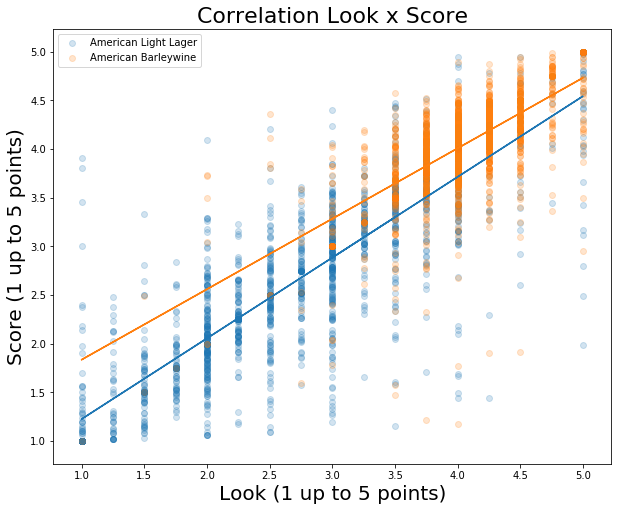

In [13]:
# Filtering beer type with the highest correlation between score and look
series = pd.Series()
for style in df["style"].value_counts().head(50).index:
    corr = df[df["style"] == style][["look", "score"]].dropna().corr()["score"]["look"]
    series = series.append(pd.Series(data=[corr], index=[style]))

higher_corr_df = df[df["style"] == series.sort_values().tail(1).index[0]].copy()
lower_corr_df =  df[df["style"] == series.sort_values().head(1).index[0]].copy()

# Data cleansing
higher_corr_df.dropna(subset=["look", "score"], how="any", inplace=True)
lower_corr_df.dropna(subset=["look", "score"], how="any", inplace=True)

# Building the chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(
    higher_corr_df["look"],
    higher_corr_df["score"],
    alpha=0.2,
    label=series.sort_values().tail(1).index[0]
)

m, b = np.polyfit(higher_corr_df["look"], higher_corr_df["score"], 1)
plt.plot(higher_corr_df["look"], m * higher_corr_df["look"] + b)

ax.scatter(
    lower_corr_df["look"],
    lower_corr_df["score"],
    alpha=0.2,
    label=series.sort_values().head(1).index[0]
)

# Fitting regression line
m, b = np.polyfit(lower_corr_df["look"], lower_corr_df["score"], 1)
plt.plot(lower_corr_df["look"], m * lower_corr_df["look"] + b)

ax.set_title("Correlation Look x Score", fontsize=22)
ax.set_ylabel("Score (1 up to 5 points)", fontsize=20)
ax.set_xlabel("Look (1 up to 5 points)", fontsize=20)
ax.legend()
plt.show()

## Time Series with shared Y Axis: Which are the highest evalueted Breweries and Countries?

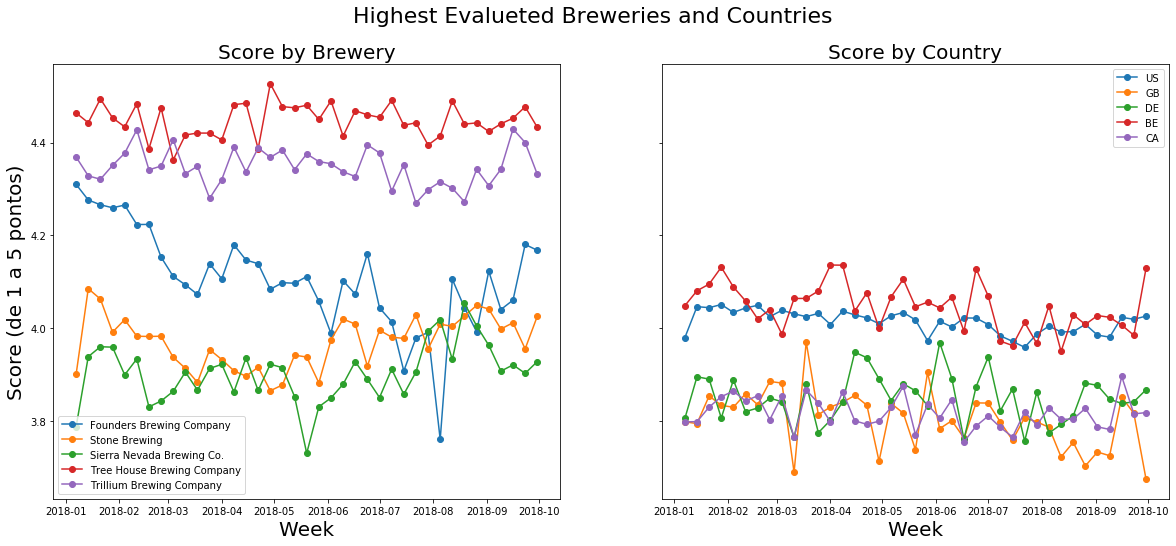

In [11]:
# Querying data from the highest evalueted breweries
most_evaluated_breweries_df = df[df["brewery_name"].isin(df["brewery_name"].value_counts().head(5).index)]
most_evaluated_breweries_df.set_index("date", inplace=True)

# Querying data from the highest evalueted countries
most_evaluated_countries_df = df[df["country"].isin(df["country"].value_counts().head(5).index)]
most_evaluated_countries_df.set_index("date", inplace=True)

# Building the chart
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

for brewery in most_evaluated_breweries_df["brewery_name"].unique():    
    ax1.plot(
        most_evaluated_breweries_df[most_evaluated_breweries_df["brewery_name"] == brewery]["score"].resample("W").mean(), label=brewery, marker="o"
    )

for country in most_evaluated_countries_df["country"].unique():    
    ax2.plot(
        most_evaluated_countries_df[most_evaluated_countries_df["country"] == country]["score"].resample("W").mean(), label=country, marker="o"
    )
    
fig.suptitle("Highest Evalueted Breweries and Countries", fontsize=22)

ax1.set_title("Score by Brewery",  fontsize=20)
ax1.set_ylabel("Score (de 1 a 5 pontos)", fontsize=20)
ax1.set_xlabel("Week",  fontsize=20)
ax1.legend()

ax2.set_title("Score by Country",  fontsize=20)
ax2.set_xlabel("Week",  fontsize=20)
ax2.legend()

plt.show()

## Bar plot with Shared Y Axis: Where are most breweries located?

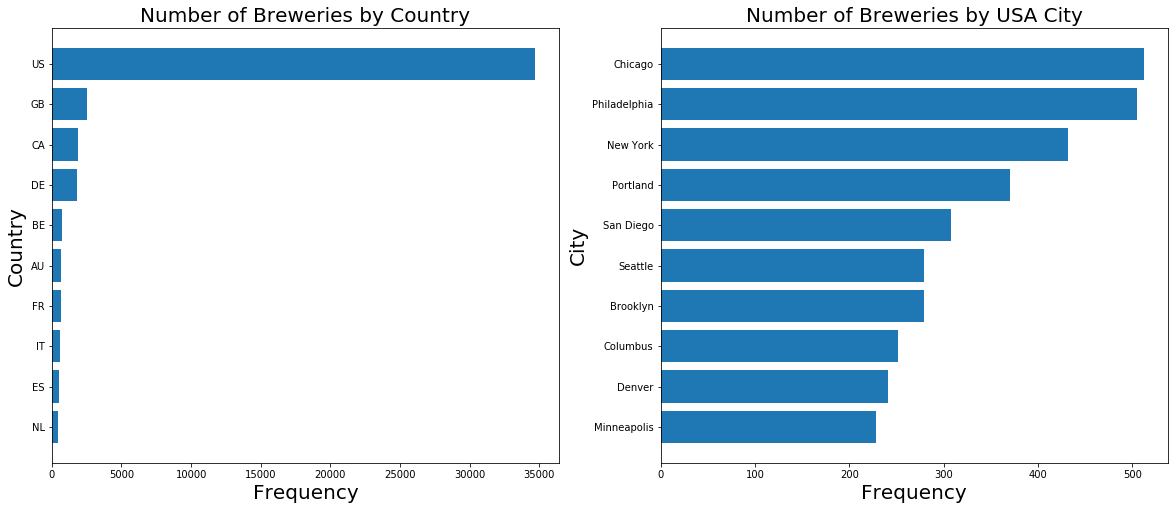

In [12]:
# Grouping data by Countries
breweries_by_country_df = breweries_df.groupby("country").count()["id"].sort_values().tail(10).to_frame()

# Grouping data by Cities
breweries_us_by_city_df = breweries_df[breweries_df["country"] == "US"].groupby("city").count()["id"].sort_values().tail(10).to_frame()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 8))
ax1.barh(breweries_by_country_df.index, breweries_by_country_df["id"])
ax2.barh(breweries_us_by_city_df.index, breweries_us_by_city_df["id"])

ax1.set_title("Number of Breweries by Country", fontsize=20)
ax1.set_xlabel("Frequency", fontsize=20)
ax1.set_ylabel("Country", fontsize=20)

ax2.set_title("Number of Breweries by USA City", fontsize=20)
ax2.set_ylabel("City", fontsize=20)
ax2.set_xlabel("Frequency", fontsize=20)

plt.show()